C:\Users\User\AppData\Local\Temp\ipykernel_20456\2938579514.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['Region'] = filtered_metadata['Region'].map(region_short_names)
C:\Users\User\AppData\Local\Temp\ipykernel_20456\2938579514.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


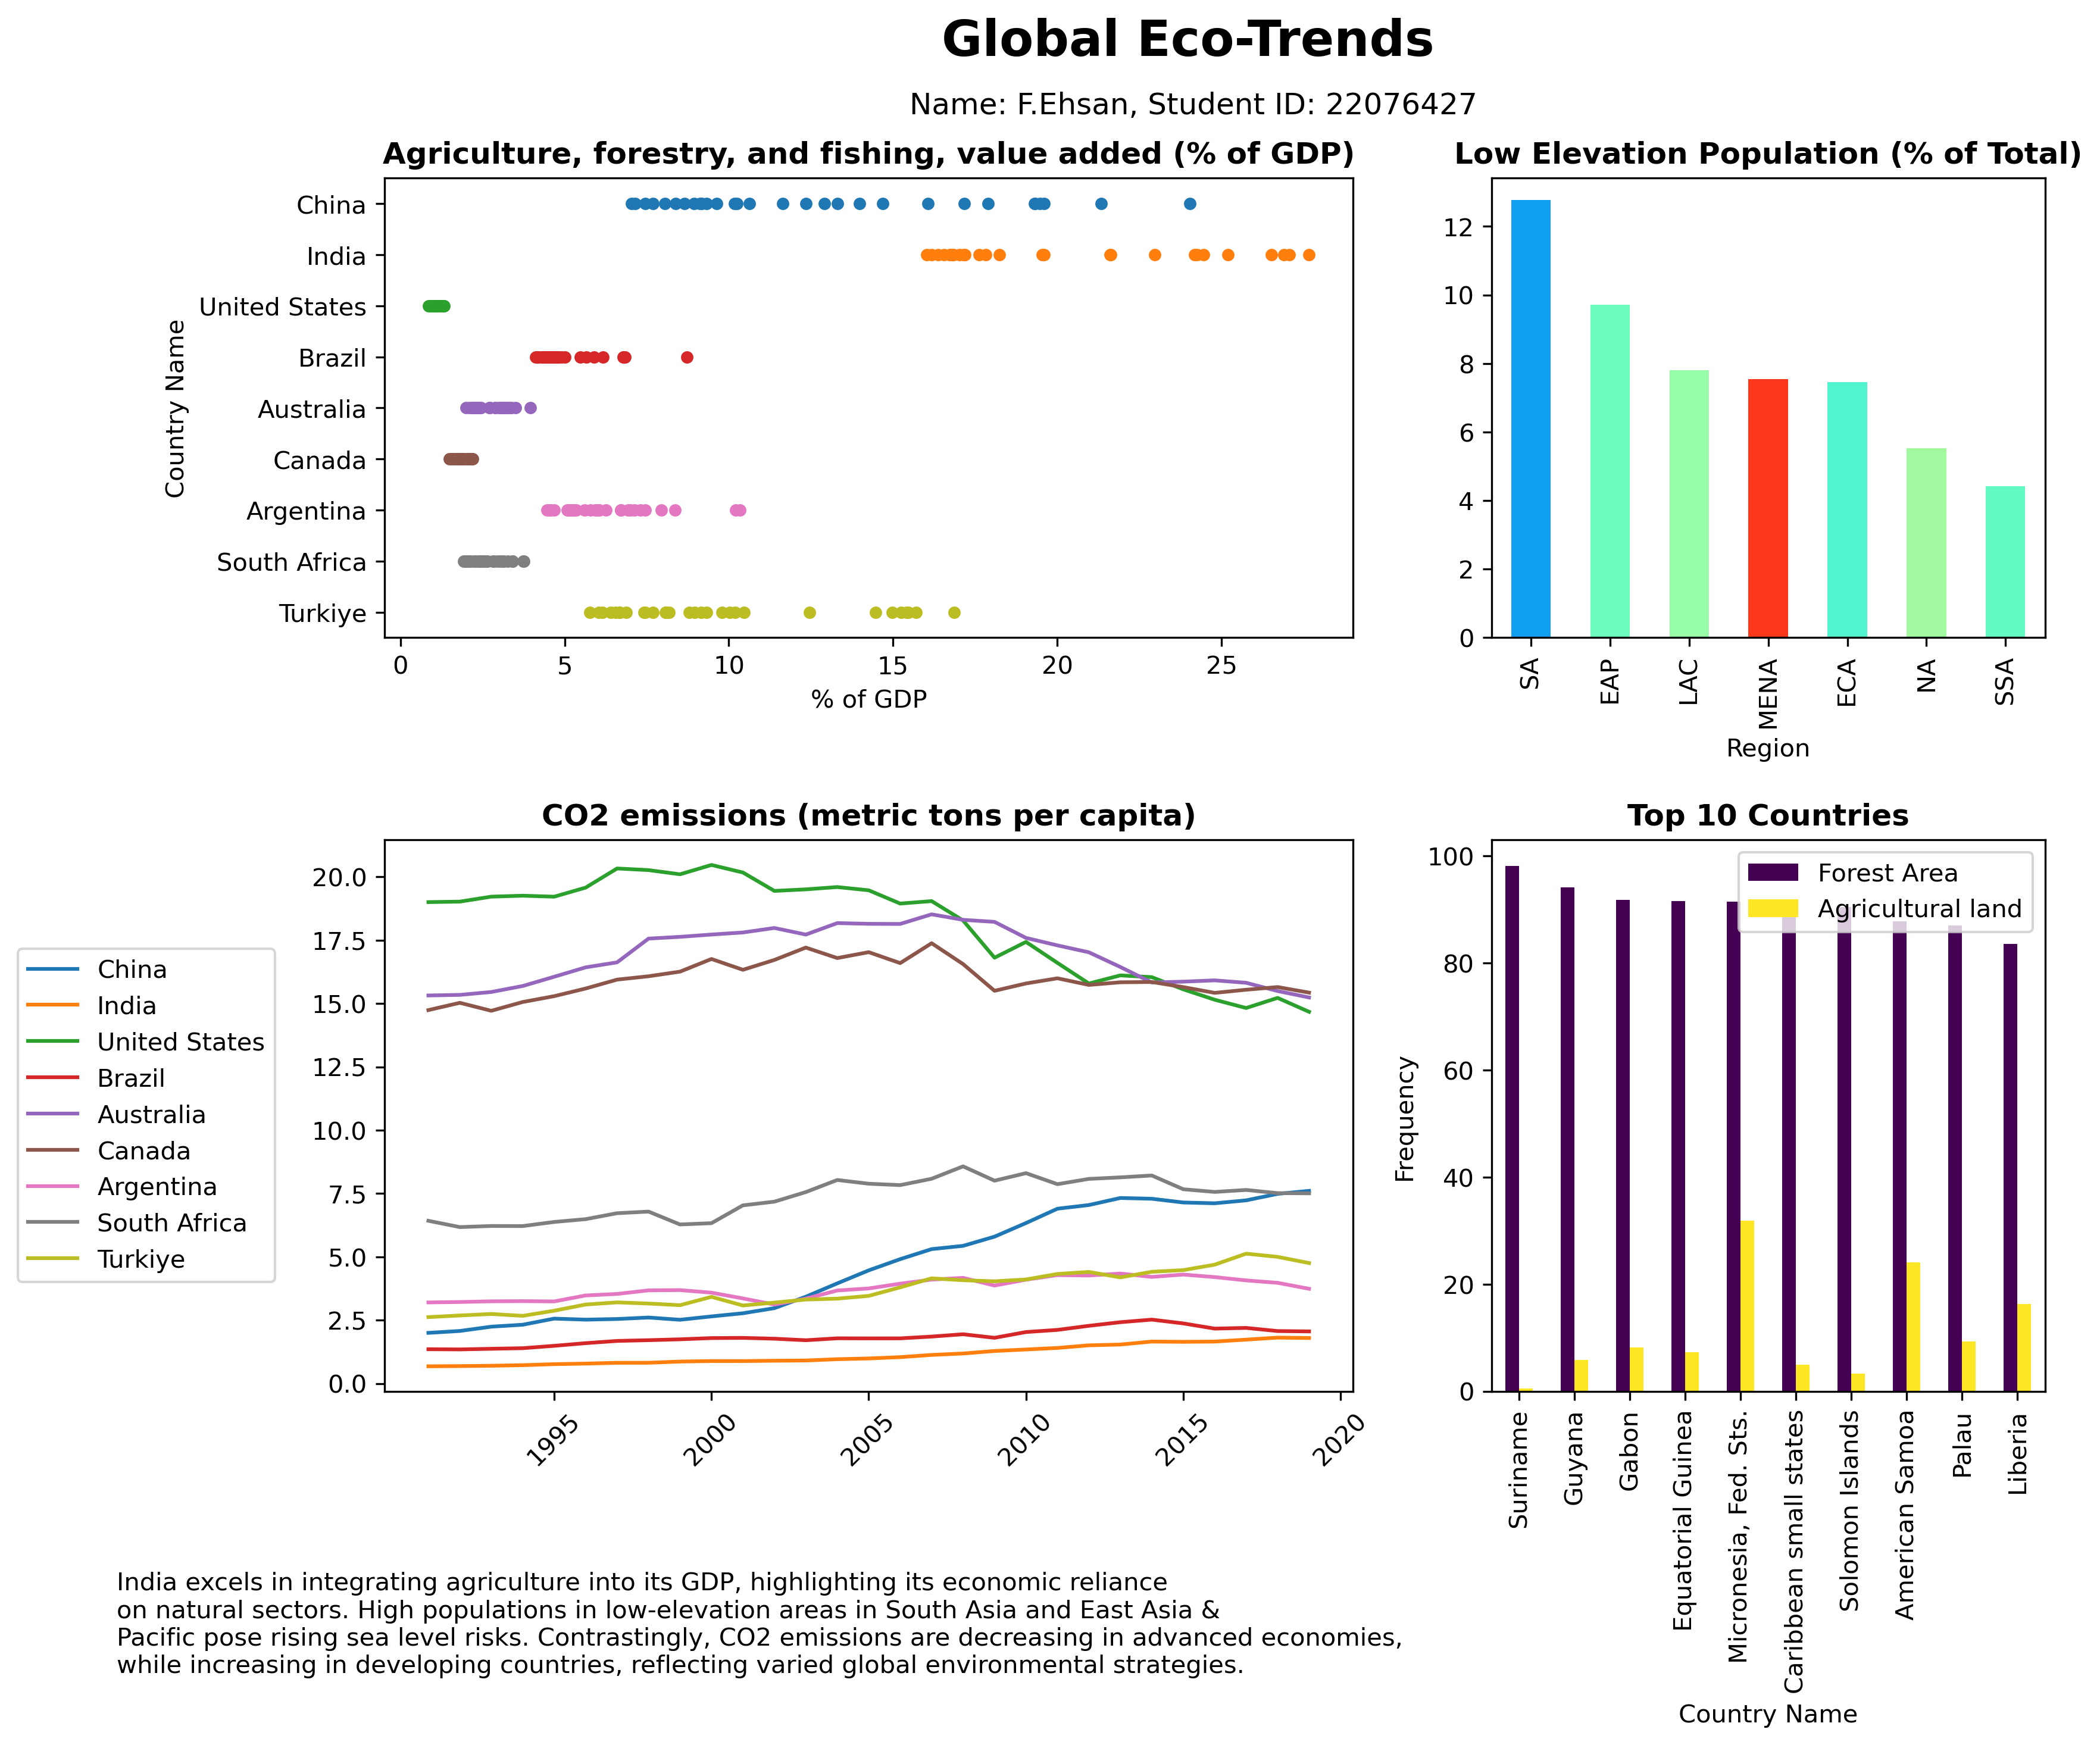

In [36]:
import random
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def process_data(data_frame, selected_indicator):
    """
    Transforms the given dataframe based on the selected indicator.

    Args:
        data_frame (DataFrame): The dataframe to process.
        selected_indicator (str): The indicator to filter the dataframe by.

    Returns:
        transposed_by_country (DataFrame): Dataframe transposed by countries.
        transposed_by_year (DataFrame): Dataframe transposed by years.
    """
    # Filtering and dropping unnecessary columns
    transposed_by_country = data_frame[data_frame['Indicator Name'] == selected_indicator]
    transposed_by_country = transposed_by_country.drop(['Indicator Name'], axis=1)
    transposed_by_country.index = transposed_by_country['Country Name']
    transposed_by_country = transposed_by_country.drop(['Country Name'], axis=1)

    # Transposing the dataframe
    transposed_by_year = transposed_by_country.transpose()
    return transposed_by_country, transposed_by_year

# Reading data from CSV files
data = pd.read_csv('data.csv')[['Country Name', 'Country Code', 'Indicator Name', 
                                'Indicator Code', '1991', '1992', '1993', '1994', '1995', 
                                '1996', '1997', '1998', '1999', '2000', '2001', '2002', 
                                '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
                                '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                                '2017', '2018', '2019', '2020']]

metadata = pd.read_csv('metadata.csv')
filtered_metadata = metadata[~pd.isna(metadata['IncomeGroup'])]

# Dictionary mapping region names
region_short_names = {
    'South Asia': 'SA',
    'Latin America & Caribbean': 'LAC',
    'Middle East & North Africa': 'MENA',
    'North America': 'NA',
    'East Asia & Pacific': 'EAP',
    'Europe & Central Asia': 'ECA',    
    'Sub-Saharan Africa': 'SSA'
}

# Replace region names
filtered_metadata['Region'] = filtered_metadata['Region'].map(region_short_names)

# List of countries of interest
selected_countries = ['China', 'India', 'United States', 'Brazil', 
                      'Australia', 'Canada', 'Argentina', 'South Africa', 'Turkiye']

# Dropping unnecessary columns
data = data.drop(['Country Code', 'Indicator Code'], axis=1)

# Processing data for population
population_by_year, population_by_country = process_data(data, 'Population, total')

# Setting up the plot grid
aspect_ratio = 2.0 / 1.0
fig = plt.figure(figsize=(12, 9), dpi=300)
gs = GridSpec(2, 3, width_ratios=[1, 2, 2], height_ratios=[1, 1.2], wspace=0.3, hspace=0.4)

# Creating subplots
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, :2])
ax4 = plt.subplot(gs[1, 2:])


# Plotting for "Agriculture, forestry, and fishing, value added (% of GDP)"
agri_forestry_fishing_gdp = "Agriculture, forestry, and fishing, value added (% of GDP)"
year_data_gdp, country_data_gdp = process_data(data, agri_forestry_fishing_gdp)
for year in year_data_gdp.columns:
    sns.swarmplot(y='Country Name', x=year, data=year_data_gdp.loc[selected_countries, :].reset_index(), ax=ax1)
ax1.set_title(agri_forestry_fishing_gdp, fontweight='bold')
ax1.set_xlabel('% of GDP')

# Plotting for "CO2 emissions (metric tons per capita)"
co2_emissions = 'CO2 emissions (metric tons per capita)'
year_data_co2, country_data_co2 = process_data(data, co2_emissions)
for country in selected_countries:
    ax3.plot(country_data_co2[country], label=country)
ax3.legend(loc='center right', bbox_to_anchor=(-0.10, 0.5))
ax3.set_xticks(['1995', '2000', '2005', '2010', '2015', '2020'])
ax3.set_xticklabels(['1995', '2000', '2005', '2010', '2015', '2020'], rotation=45)
ax3.set_title('CO2 emissions (metric tons per capita)', fontweight='bold')

# Plotting for "Population living in areas where elevation is below 5 meters (% of total population)"
low_elevation_pop = 'Population living in areas where elevation is below 5 meters (% of total population)'
data['mean'] = data.iloc[:, 4:].mean(axis=1)
temp_data = data[data['Indicator Name'] == low_elevation_pop]
temp_data = temp_data.merge(filtered_metadata, left_on='Country Name', right_on='TableName')
colors = [cm.rainbow(random.random()) for _ in range(len(temp_data.Region.unique()))]
temp_data.groupby(['Region'])['mean'].mean().sort_values(ascending=False).plot(kind='bar', color=colors, ax=ax2)
ax2.set_title('Low Elevation Population (% of Total)', fontweight='bold')
ax2.set_xlabel('Region')

# Plotting for "Forest area (% of land area)" and "Agricultural land (% of land area)"
forest_area = 'Forest area (% of land area)'
agricultural_land = 'Agricultural land (% of land area)'
forest_data, _ = process_data(data, forest_area)
agri_land_data, _ = process_data(data, agricultural_land)
forest_mean = forest_data.mean(axis=1).reset_index().rename({0: 'Forest Area'}, axis=1)
agri_land_mean = agri_land_data.mean(axis=1).reset_index().rename({0: 'Agricultural land'}, axis=1)
merged_data = forest_mean.merge(agri_land_mean, on='Country Name')
merged_data.index = merged_data['Country Name']
merged_data.sort_values(by='Forest Area', ascending=False)[:10].plot(kind='bar', ax=ax4, colormap='viridis')
ax4.set_title('Top 10 Countries', fontweight='bold')
ax4.set_ylabel('Frequency')

# Overall figure title and additional text
fig.suptitle('Global Eco-Trends', fontsize=20, fontweight='bold')
fig.text(0.37, 0.92, 'Name: F.Ehsan, Student ID: 22076427', fontsize=12)
additional_text = """India excels in integrating agriculture into its GDP, highlighting its economic reliance 
on natural sectors. High populations in low-elevation areas in South Asia and East Asia & 
Pacific pose rising sea level risks. Contrastingly, CO2 emissions are decreasing in advanced economies, 
while increasing in developing countries, reflecting varied global environmental strategies."""
fig.text(0.0, -0.05, additional_text, fontsize=10)

plt.tight_layout()


plt.show()